In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

In [54]:
plt.rcParams["figure.figsize"] = (9,9)
plt.rcParams["font.size"] = 14

In [55]:
customers = pd.read_csv("customer_all.csv")

In [56]:
customers

,customer_id,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,owns_car,tenure,age,address,postcode,state,property_valuation,total_profit,n_transaction,profit_per_transaction,diverging_job_title,post_code_cut,diverging_post_code
0,1,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,Yes,11,63,060 Morning Avenue,2016,NSW,10,3018.09,11,274.371818,Other,"[1950,2050]",Other
1,2,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,Yes,16,36,6 Meadow Vale Court,2153,NSW,10,2226.26,3,742.086667,Other,"(2150,2250]",Other
2,5,Female,56,1977-05-13,Senior Editor,NaN,Affluent Customer,Yes,8,40,17979 Del Mar Point,2448,NSW,4,2394.94,6,399.156667,Other,"(2350,2450]",Other
3,8,Male,31,1962-03-30,Media Manager,NaN,Mass Customer,No,7,55,49 Londonderry Lane,2650,NSW,4,7066.94,10,706.694000,Media Manager,"(2550,2650]",Other
4,9,Female,97,1973-03-10,Business Systems Development Analyst,Argiculture,Affluent Customer,Yes,8,44,97736 7th Trail,2023,NSW,12,2353.11,6,392.185000,Other,"[1950,2050]",Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3408,3994,Female,5,1989-04-07,Structural Analysis Engineer,Manufacturing,Affluent Customer,No,12,28,2918 Summer Ridge Hill,3030,VIC,2,0.00,0,0.000000,Other,"(2950,3050]","(2950,3050]"
3409,3995,Male,93,1975-12-12,Staff Scientist,Manufacturing,Mass Customer,Yes,14,41,613 Erie Lane,2088,NSW,12,0.00,0,0.000000,Other,"(2050,2150]",Other
3410,3996,Female,8,1975-08-09,VP Product Management,Health,Mass Customer,No,19,41,0 Transport Center,3977,VIC,6,0.00,0,0.000000,Other,"(3950,4050]",Other
3411,3997,Female,87,2001-07-13,Statistician,Manufacturing,High Net Worth,Yes,1,15,4 Dovetail Crossing,2350,NSW,2,0.00,0,0.000000,Other,"(2250,2350]",Other


# Variables

In [57]:
y = customers.profit_per_transaction.values

scale_y = StandardScaler()

y = scale_y.fit_transform(y.reshape(-1,1)).flatten()

customers["scaled_y"] = y

In [179]:
x_num = customers[["age", "property_valuation"]].values

scale_x = StandardScaler()

x_num = scale_x.fit_transform(x_num)


In [156]:
onehot = OneHotEncoder()

x_cat = onehot.fit_transform(customers[["gender", "wealth_segment", "owns_car", "state", "diverging_job_title", "diverging_post_code"]]).toarray()

In [71]:
onehot2 = OneHotEncoder()

x_cat_jobs = onehot2.fit_transform(customers.job_title.values.reshape(-1,1)).toarray()

In [180]:
x_all = np.concatenate([x_num, x_cat], axis = 1)

In [182]:
x_all.shape, x_cat.shape

((3413, 38), (3413, 36))

# MLP

In [212]:
mlp = MLPRegressor(max_iter=900, n_iter_no_change=20)

param_grid = [
    {"hidden_layer_sizes" : [5, 10, 20, 30, 50], "alpha" : [0.7, 0.9, 0.99]}
]

scores_mlp = GridSearchCV(mlp, param_grid=param_grid, cv = 5, refit = True, verbose=3,
                     scoring="r2", n_jobs=4)

scores_mlp.fit(x_cat, y)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5, estimator=MLPRegressor(max_iter=900, n_iter_no_change=20),
             n_jobs=4,
             param_grid=[{'alpha': [0.7, 0.9, 0.99],
                          'hidden_layer_sizes': [5, 10, 20, 30, 50]}],
             scoring='r2', verbose=3)

In [213]:
pd.DataFrame(scores_mlp.cv_results_).sort_values("rank_test_score").T

,12,11,13,8,6,10,7,0,9,5,14,1,2,3,4
mean_fit_time,1.245326,0.981821,1.34036,1.597565,0.956342,0.966296,1.360226,0.722265,1.571575,0.760112,1.70148,1.063662,1.455008,1.461911,1.753533
std_fit_time,0.186978,0.178292,0.113439,0.134237,0.180721,0.202556,0.094892,0.243051,0.25593,0.167052,0.252101,0.18167,0.194951,0.167765,0.320892
mean_score_time,0.0008,0.0002,0.0008,0.0008,0.0004,0.000599,0.0004,0.0008,0.0004,0.0,0.001,0.000599,0.0002,0.001,0.0006
std_score_time,0.0004,0.0004,0.0004,0.0004,0.00049,0.000489,0.00049,0.0004,0.00049,0.0,0.0,0.000489,0.0004,0.0,0.00049
param_alpha,0.99,0.99,0.99,0.9,0.9,0.99,0.9,0.7,0.9,0.9,0.99,0.7,0.7,0.7,0.7
param_hidden_layer_sizes,20,10,30,30,10,5,20,5,50,5,50,10,20,30,50
params,"{'alpha': 0.99, 'hidden_layer_sizes': 20}","{'alpha': 0.99, 'hidden_layer_sizes': 10}","{'alpha': 0.99, 'hidden_layer_sizes': 30}","{'alpha': 0.9, 'hidden_layer_sizes': 30}","{'alpha': 0.9, 'hidden_layer_sizes': 10}","{'alpha': 0.99, 'hidden_layer_sizes': 5}","{'alpha': 0.9, 'hidden_layer_sizes': 20}","{'alpha': 0.7, 'hidden_layer_sizes': 5}","{'alpha': 0.9, 'hidden_layer_sizes': 50}","{'alpha': 0.9, 'hidden_layer_sizes': 5}","{'alpha': 0.99, 'hidden_layer_sizes': 50}","{'alpha': 0.7, 'hidden_layer_sizes': 10}","{'alpha': 0.7, 'hidden_layer_sizes': 20}","{'alpha': 0.7, 'hidden_layer_sizes': 30}","{'alpha': 0.7, 'hidden_layer_sizes': 50}"
split0_test_score,-0.043837,-0.03716,-0.017327,-0.024992,-0.03001,-0.034319,-0.036237,-0.026231,-0.02876,-0.033661,-0.048228,-0.045091,-0.023794,-0.052602,-0.023611
split1_test_score,-0.00837,-0.01113,-0.008156,-0.012741,0.00162,-0.010177,0.00581,0.007096,-0.014682,-0.017885,-0.021878,-0.022061,-0.029148,-0.019092,-0.016759
split2_test_score,-0.091902,-0.090702,-0.088939,-0.102334,-0.101324,-0.10331,-0.102554,-0.103056,-0.084658,-0.109286,-0.068587,-0.100749,-0.10438,-0.109695,-0.131053


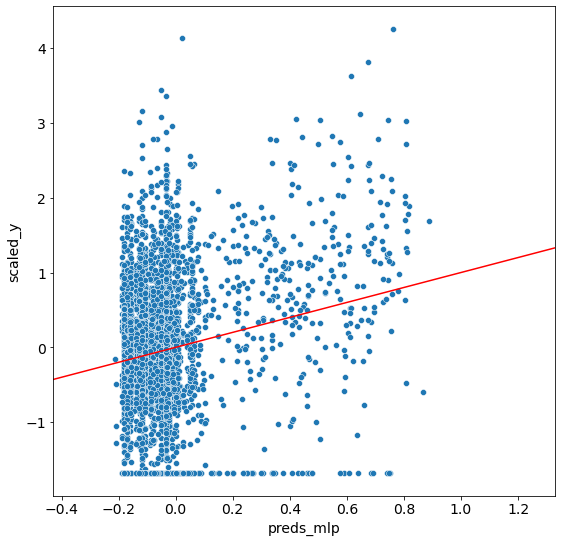

In [215]:
customers["preds_mlp"] = scores_mlp.predict(x_cat)

sns.scatterplot(x = "preds_mlp", y = "scaled_y", data = customers)
plt.axline([-0.35,-0.35], [1.25, 1.25], c = "red")

# Gradient Boosting

In [216]:
xgb = GradientBoostingRegressor()

param_grid = [
    {"learning_rate" : [0.005, 0.01], "n_estimators" : [100, 250, 500, 600],
    "max_depth" : [2, 3]}
]

scores_xgb = GridSearchCV(xgb, param_grid=param_grid, cv = 5, refit=True, verbose=3,
                     scoring="r2", n_jobs=4)

scores_xgb.fit(x_cat, y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=4,
             param_grid=[{'learning_rate': [0.005, 0.01], 'max_depth': [2, 3],
                          'n_estimators': [100, 250, 500, 600]}],
             scoring='r2', verbose=3)

In [217]:
pd.DataFrame(scores_xgb.cv_results_).sort_values("rank_test_score").T

,11,10,3,7,6,2,13,9,14,15,5,12,1,8,4,0
mean_fit_time,0.688248,0.593108,0.689911,0.928826,0.77751,0.578596,0.391361,0.292614,0.802227,0.942741,0.379052,0.15059,0.295845,0.120241,0.144599,0.131198
std_fit_time,0.012359,0.016465,0.00402,0.014497,0.016817,0.009992,0.008941,0.007596,0.017148,0.020638,0.007512,0.005066,0.015474,0.007176,0.001855,0.002925
mean_score_time,0.003,0.002391,0.0026,0.0042,0.0034,0.0026,0.002,0.001,0.0036,0.003806,0.0022,0.001007,0.0014,0.001,0.0014,0.001601
std_score_time,0.0,0.00048,0.00049,0.000981,0.00049,0.00049,0.000632,0.000001,0.00049,0.000403,0.0004,0.000012,0.00049,0.000001,0.00049,0.000491
param_learning_rate,0.01,0.01,0.005,0.005,0.005,0.005,0.01,0.01,0.01,0.01,0.005,0.01,0.005,0.01,0.005,0.005
param_max_depth,2,2,2,3,3,2,3,2,3,3,3,3,2,2,3,2
param_n_estimators,600,500,600,600,500,500,250,250,500,600,250,100,250,100,100,100
params,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...","{'learning_rate': 0.01, 'max_depth': 2, 'n_est...","{'learning_rate': 0.005, 'max_depth': 2, 'n_es...","{'learning_rate': 0.005, 'max_depth': 3, 'n_es...","{'learning_rate': 0.005, 'max_depth': 3, 'n_es...","{'learning_rate': 0.005, 'max_depth': 2, 'n_es...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...","{'learning_rate': 0.01, 'max_depth': 2, 'n_est...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...","{'learning_rate': 0.005, 'max_depth': 3, 'n_es...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...","{'learning_rate': 0.005, 'max_depth': 2, 'n_es...","{'learning_rate': 0.01, 'max_depth': 2, 'n_est...","{'learning_rate': 0.005, 'max_depth': 3, 'n_es...","{'learning_rate': 0.005, 'max_depth': 2, 'n_es..."
split0_test_score,-0.027301,-0.029333,-0.034738,-0.034424,-0.035281,-0.037052,-0.036019,-0.040588,-0.032152,-0.0334,-0.055409,-0.061259,-0.055373,-0.063072,-0.079823,-0.080406
split1_test_score,-0.011889,-0.013069,-0.01583,-0.013951,-0.014612,-0.017952,-0.018243,-0.01872,-0.02161,-0.024142,-0.026569,-0.030759,-0.03219,-0.036801,-0.047996,-0.052768


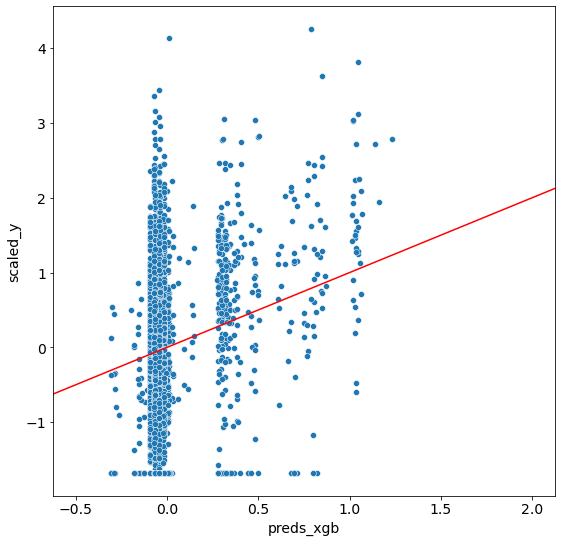

In [218]:
customers["preds_xgb"] = scores_xgb.predict(x_cat)

sns.scatterplot(x = "preds_xgb", y = "scaled_y", data = customers)
plt.axline([-0.5,-0.5], [2, 2], c = "red")

# SVM 

In [257]:
svm = SVR()

param_grid = [
    {"kernel" : ["rbf"], "C" : [0.1, 0.2, 0.3, 0.35, 0.4]}
]

scores_svm = GridSearchCV(svm, param_grid=param_grid, cv = 5, refit = True, verbose=3,
                     scoring="r2", n_jobs=4)

scores_svm.fit(x_cat,y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=4,
             param_grid=[{'C': [0.1, 0.2, 0.3, 0.35, 0.4], 'kernel': ['rbf']}],
             scoring='r2', verbose=3)

In [258]:
pd.DataFrame(scores_svm.cv_results_).sort_values("rank_test_score").T

,3,2,4,1,0
mean_fit_time,0.364564,0.365376,0.394971,0.366467,0.382671
std_fit_time,0.010745,0.011936,0.033727,0.017036,0.011088
mean_score_time,0.177321,0.173053,0.199367,0.177042,0.168513
std_score_time,0.006044,0.004076,0.024827,0.00621,0.001257
param_C,0.35,0.3,0.4,0.2,0.1
param_kernel,rbf,rbf,rbf,rbf,rbf
params,"{'C': 0.35, 'kernel': 'rbf'}","{'C': 0.3, 'kernel': 'rbf'}","{'C': 0.4, 'kernel': 'rbf'}","{'C': 0.2, 'kernel': 'rbf'}","{'C': 0.1, 'kernel': 'rbf'}"
split0_test_score,0.019143,0.016526,0.020585,0.007272,-0.005516
split1_test_score,0.027007,0.025704,0.02809,0.025523,0.017685
split2_test_score,-0.047435,-0.047759,-0.047767,-0.04839,-0.052745


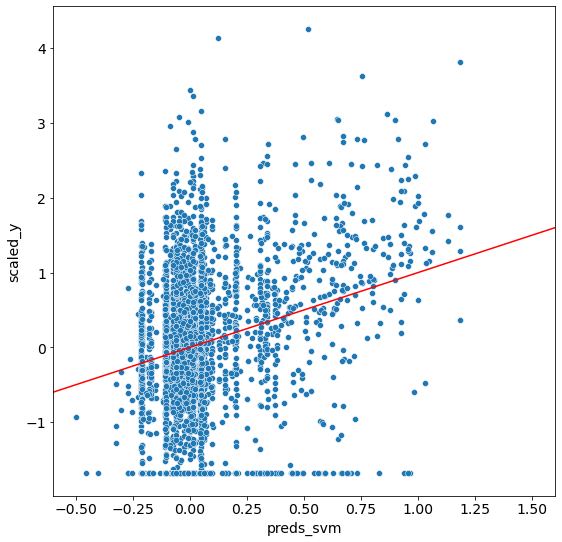

In [259]:
customers["preds_svm"] = scores_svm.predict(x_cat)

sns.scatterplot(x = "preds_svm", y = "scaled_y", data = customers)
plt.axline([-0.5,-0.5], [1.5, 1.5], c = "red")

# RF

In [225]:
rf = RandomForestRegressor()

param_grid = [
    {"n_estimators" : [300, 600, 900, 1200], "max_depth" : [5, 6, 7]}
]

scores_rf = GridSearchCV(rf, param_grid=param_grid, cv = 5, refit = True, verbose=3,
                     scoring="r2", n_jobs=4)

scores_rf.fit(x_cat,y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=4,
             param_grid=[{'max_depth': [5, 6, 7],
                          'n_estimators': [300, 600, 900, 1200]}],
             scoring='r2', verbose=3)

In [226]:
pd.DataFrame(scores_rf.cv_results_).sort_values("rank_test_score").head(7).T

,3,1,6,5,0,7,2
mean_fit_time,2.277635,1.191263,1.823367,1.229587,0.616915,2.467591,1.764162
std_fit_time,0.071012,0.051118,0.04719,0.02802,0.029818,0.016327,0.039672
mean_score_time,0.082618,0.041999,0.0666,0.04682,0.022454,0.089457,0.063615
std_score_time,0.001963,0.001095,0.001357,0.004161,0.001854,0.003515,0.002661
param_max_depth,5,5,6,6,5,6,5
param_n_estimators,1200,600,900,600,300,1200,900
params,"{'max_depth': 5, 'n_estimators': 1200}","{'max_depth': 5, 'n_estimators': 600}","{'max_depth': 6, 'n_estimators': 900}","{'max_depth': 6, 'n_estimators': 600}","{'max_depth': 5, 'n_estimators': 300}","{'max_depth': 6, 'n_estimators': 1200}","{'max_depth': 5, 'n_estimators': 900}"
split0_test_score,-0.037891,-0.040606,-0.041158,-0.04087,-0.040564,-0.040841,-0.042112
split1_test_score,-0.010745,-0.010841,-0.013845,-0.013657,-0.011121,-0.014385,-0.012128
split2_test_score,-0.103652,-0.103233,-0.105014,-0.104535,-0.105311,-0.10923,-0.103679


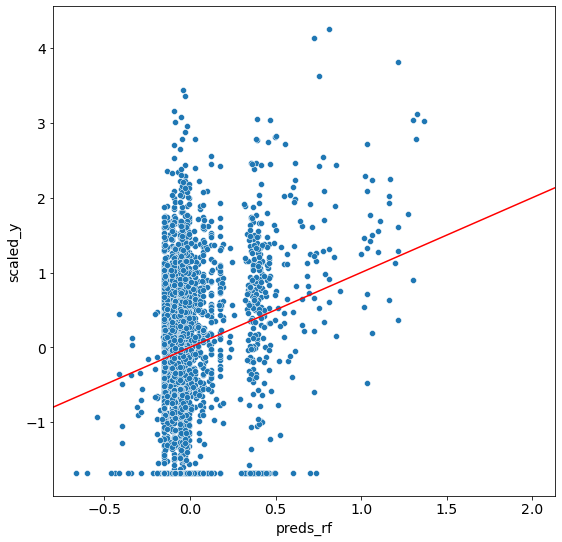

In [227]:
customers["preds_rf"] = scores_rf.predict(x_cat)

sns.scatterplot(x = "preds_rf", y = "scaled_y", data = customers)
plt.axline([-0.5,-0.5], [2, 2], c = "red")

In [261]:
customers["ensemble"] = (customers.preds_rf + customers.preds_svm + customers.preds_xgb) / 3

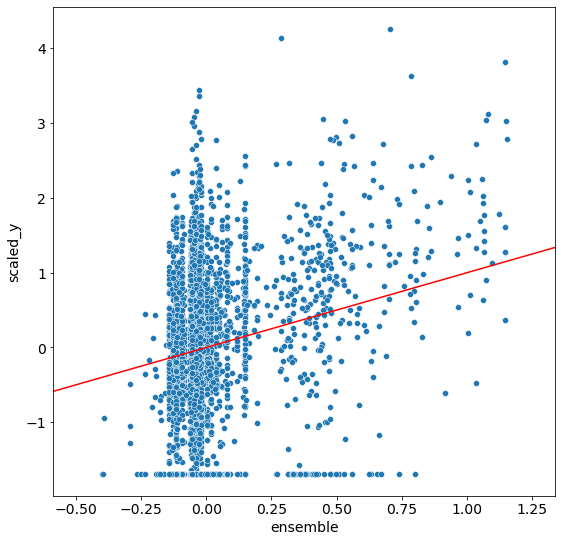

In [265]:
sns.scatterplot(x = "ensemble", y = "scaled_y", data = customers)
plt.axline([-0.5,-0.5], [1.25, 1.25], c = "red")

In [236]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [263]:
r2_score(customers.scaled_y.values, customers.ensemble.values), mean_squared_error(customers.scaled_y.values, customers.ensemble.values)

(0.07281054046358448, 0.9271894595364157)

In [264]:
r2_score(customers.scaled_y.values, customers.preds_svm.values), mean_squared_error(customers.scaled_y.values, customers.preds_svm.values)

(0.07258211248029023, 0.92741788751971)

In [266]:
r2_score(customers.scaled_y.values, customers.preds_mlp.values), mean_squared_error(customers.scaled_y.values, customers.preds_mlp.values)

(0.05344518043497859, 0.9465548195650217)

# Getting prediction from the New Customer Data 

In [267]:
new_customers = pd.read_csv("new_customers.csv")

In [269]:
onehot_pred = OneHotEncoder()

new_x_cat = onehot_pred.fit_transform(new_customers[["gender", "wealth_segment", "owns_car", "state", "diverging_job_title", "diverging_post_code"]]).toarray()

In [271]:
new_x_cat.shape

(878, 36)

In [274]:
new_customers["preds_svm"] = scores_svm.predict(new_x_cat)
new_customers["preds_xgb"] = scores_xgb.predict(new_x_cat)
new_customers["preds_rf"] = scores_rf.predict(new_x_cat)

In [275]:
new_customers["ensemble"] = (new_customers.preds_rf + new_customers.preds_svm + new_customers.preds_xgb) / 3

In [277]:
new_customers.sort_values(by = "ensemble", ascending=False)

,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,owns_car,tenure,address,postcode,state,property_valuation,age,diverging_job_title,post_code_cut,diverging_post_code,preds_svm,preds_xgb,preds_rf,ensemble
279,Male,78,1976-11-06,Information Systems Manager,NaN,High Net Worth,Yes,7,3 Express Lane,3021,VIC,7,40,Information Systems Manager,"(2950,3050]","(2950,3050]",0.923645,1.453482,1.179435,1.185521
624,Female,82,1963-10-16,Project Manager,Telecommunications,Mass Customer,Yes,10,6 Meadow Ridge Pass,2470,NSW,2,53,Project Manager,"(2450,2550]",Other,1.182160,1.045929,1.213043,1.147044
781,Male,57,1956-10-05,Project Manager,IT,Mass Customer,Yes,9,1 Mandrake Way,3844,VIC,1,60,Project Manager,"(3750,3850]",Other,1.026223,1.065731,1.274057,1.122004
818,Female,5,1960-08-31,Project Manager,Manufacturing,Mass Customer,No,6,9 Washington Center,3340,VIC,4,56,Project Manager,"(3250,3350]",Other,0.864875,1.043839,1.327748,1.078821
96,Male,64,1946-07-09,Information Systems Manager,Telecommunications,Affluent Customer,Yes,17,7 Cascade Park,2089,NSW,9,70,Information Systems Manager,"(2050,2150]",Other,0.898866,1.018784,1.301993,1.073214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,Male,52,1963-09-01,Senior Developer,NaN,High Net Worth,Yes,17,44 Ronald Regan Parkway,4352,QLD,7,53,Other,"(4350,4450]","(4350,4450]",-0.287713,-0.032289,-0.137247,-0.152417
107,Female,42,1940-02-02,Editor,Retail,Mass Customer,No,12,1 Bluejay Place,4405,QLD,1,77,Other,"(4350,4450]","(4350,4450]",-0.228254,-0.155784,-0.203360,-0.195799
249,Female,88,1967-01-09,Pharmacist,Health,Mass Customer,No,11,351 Sunfield Lane,4370,QLD,7,50,Other,"(4350,4450]","(4350,4450]",-0.228254,-0.155784,-0.203360,-0.195799
407,Female,50,2001-08-04,Graphic Designer,IT,Mass Customer,No,14,0 Memorial Road,3109,VIC,10,15,Graphic Designer,"(3050,3150]",Other,-0.094433,-0.309555,-0.414039,-0.272676


<AxesSubplot:xlabel='ensemble', ylabel='diverging_job_title'>

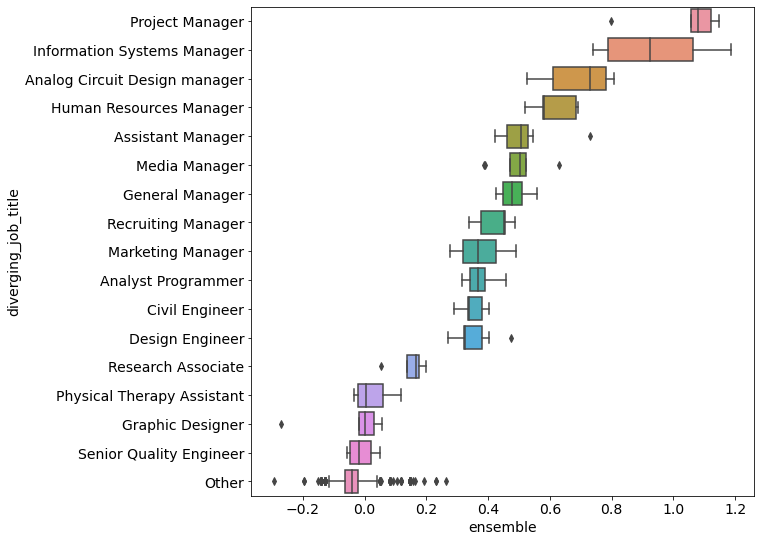

In [289]:
sort_order = new_customers[["ensemble","diverging_job_title"]].groupby("diverging_job_title").median().sort_values("ensemble", ascending=False).index

sns.boxplot(x = "ensemble", y = "diverging_job_title", data = new_customers, order = sort_order)

<AxesSubplot:xlabel='ensemble', ylabel='diverging_post_code'>

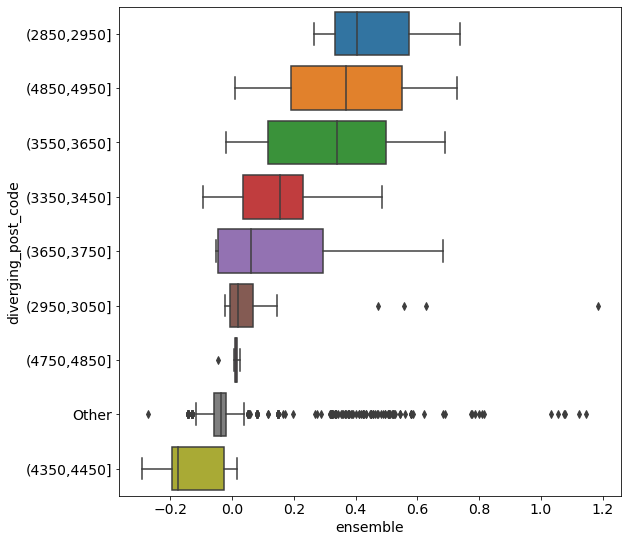

In [290]:
sort_order = new_customers[["ensemble","diverging_post_code"]].groupby("diverging_post_code").median().sort_values("ensemble", ascending=False).index

sns.boxplot(x = "ensemble", y = "diverging_post_code", data = new_customers, order = sort_order)

<AxesSubplot:xlabel='ensemble', ylabel='gender'>

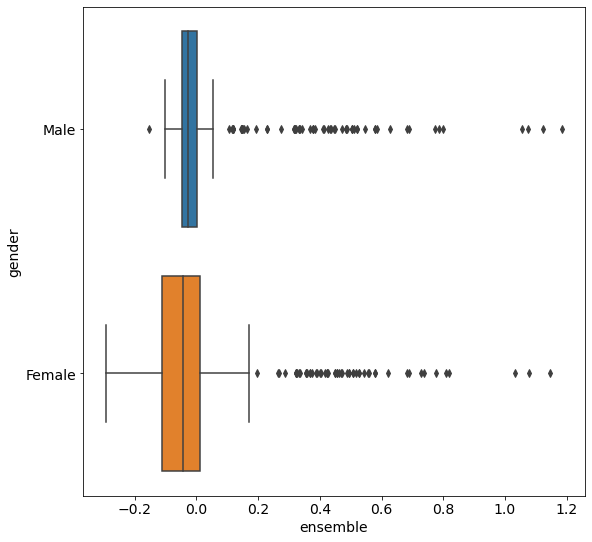

In [291]:
sort_order = new_customers[["ensemble","gender"]].groupby("gender").median().sort_values("ensemble", ascending=False).index

sns.boxplot(x = "ensemble", y = "gender", data = new_customers, order = sort_order)

<AxesSubplot:xlabel='ensemble', ylabel='owns_car'>

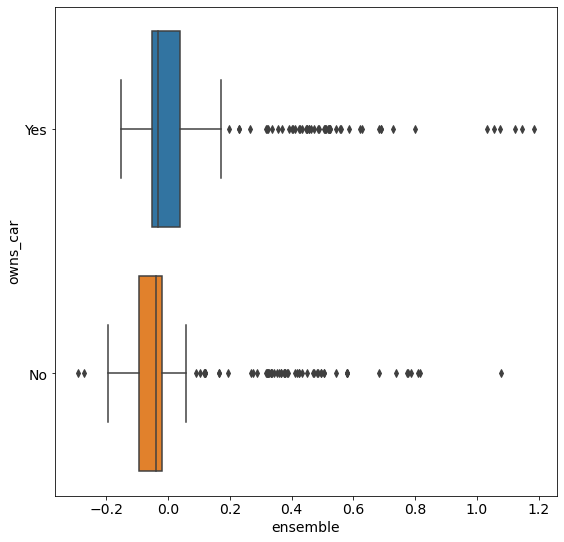

In [293]:
sort_order = new_customers[["ensemble","owns_car"]].groupby("owns_car").median().sort_values("ensemble", ascending=False).index

sns.boxplot(x = "ensemble", y = "owns_car", data = new_customers, order = sort_order)

<AxesSubplot:xlabel='ensemble', ylabel='state'>

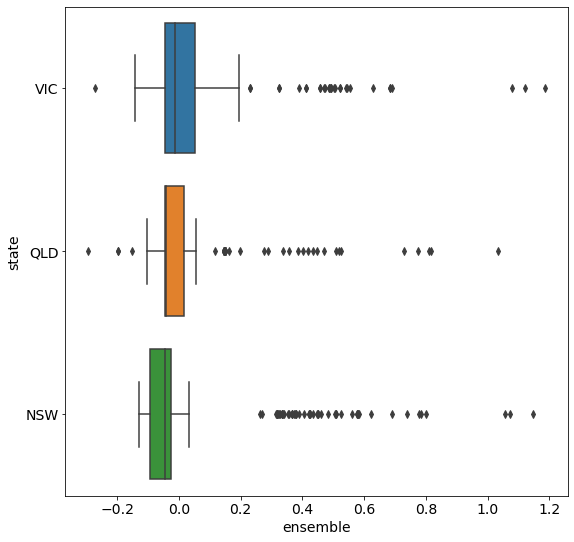

In [294]:
sort_order = new_customers[["ensemble","state"]].groupby("state").median().sort_values("ensemble", ascending=False).index

sns.boxplot(x = "ensemble", y = "state", data = new_customers, order = sort_order)